# Computer Vision Capstone: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the agricultural sector has faced an urgent need for modernization due to the extensive manual labor required to monitor plant growth. Despite advancements in agricultural technology, workers still spend significant time and effort sorting and recognizing different plants and weeds. This **trillion-dollar industry** stands to benefit greatly from technological innovations that **reduce the need for manual labor**. Artificial Intelligence, particularly **AI and Deep Learning**, can significantly streamline the process of identifying plant seedlings. This efficiency not only surpasses that of experienced manual labor but also enhances crop yields, frees up human resources for higher-order agricultural decision-making, and promotes more sustainable environmental practices in agriculture.

### Objective

Develop a Convolutional Neural Network to accurately classify images of plant seedlings into their respective categories by species label.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, released a dataset containing **images of unique plants belonging to 12 different species.**

**List of Species**

- Black-Grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-Bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-Flowered Cranesbill
- Sugar Beet

## Importing Necessary Libraries

In [1]:
!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, restart notebook kernel and run all subsequent cells sequentially.*

In [2]:
import os
import numpy as np                                                                               # Importing numpy for matrix operations
import pandas as pd                                                                              # Importing pandas to read .csv files
import matplotlib.pyplot as plt                                                                  # Importing matplotlib for plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs

# Tensorflow modules

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential, Model                                            # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization # Defining all the layers used to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers for use in the model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay      # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer

# Display images using OpenCV

from tensorflow.keras import backend
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications import ResNet50

import random

# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [3]:
# Load the images file of dataset using NumPy

images = np.load('images.npy')     

# Load the labels file of dataset using pandas

labels = pd.read_csv('Labels.csv')  

## Data Overview

### Check the Shape of the Dataset

In [4]:
# Use the .print and .shape functions to display the shape of 'images' and 'labels'

print("Shape of Images:", images.shape)
print("Shape of Labels:", labels.shape)

Shape of Images: (4750, 128, 128, 3)
Shape of Labels: (4750, 1)


#### Observations:

* The "images.npy" dataset contains **4750 images** with **heights of 128 pixels**, **widths of 128 pixels**, and **3 color channels**.
* The "Labels.csv" dataset contains **4750 rows** with **1 column**.

### Map Label Data

In [5]:
# Ensure labels are title case and create the mapping dictionary

species_list = [
    "Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common Wheat",
    "Fat Hen", "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse",
    "Small-flowered Cranesbill", "Sugar Beet"]

species_list = [species.title() for species in species_list]
species_to_class = {species: i for i, species in enumerate(species_list)}

In [6]:
# Normalize labels to title case

labels['Label'] = labels['Label'].str.title()
labels['Class'] = labels['Label'].map(species_to_class)

In [7]:
# Add a column for the image index

labels['Index'] = labels.index

In [8]:
# Use the .info function to display updates to DataFrame

labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
 1   Class   4750 non-null   int64 
 2   Index   4750 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 111.5+ KB


In [9]:
# Use the .head function to display updates to DataFrame

labels.head()

Label  Class  Index
0  Small-Flowered Cranesbill     10      0
1  Small-Flowered Cranesbill     10      1
2  Small-Flowered Cranesbill     10      2
3  Small-Flowered Cranesbill     10      3
4  Small-Flowered Cranesbill     10      4

In [10]:
# Use the .tail function to display updates to DataFrame

labels.tail()

Label  Class  Index
4745  Loose Silky-Bent      6   4745
4746  Loose Silky-Bent      6   4746
4747  Loose Silky-Bent      6   4747
4748  Loose Silky-Bent      6   4748
4749  Loose Silky-Bent      6   4749

#### Observations:

The labels DataFrame has successfully added a class and index column to increase machine learning compatibility and changed the individual labels to title case to improve readability by users.

## Exploratory Data Analysis

In [11]:
def plot_samples_by_class(images, labels, num_samples=5):
    """
    Plot random samples from each class.

    Parameters:
    images (np.array): Array of images.
    labels (pd.DataFrame): DataFrame containing image labels and corresponding class information.
    num_samples (int): Number of random samples to plot for each class.

    Returns:
    None
    """
    unique_classes = labels['Class'].unique()  # Get unique class labels
    fig, axes = plt.subplots(len(unique_classes), num_samples, figsize=(num_samples * 3, len(unique_classes) * 3))  # Create subplots

    for i, class_label in enumerate(unique_classes):
        class_images = images[labels['Class'] == class_label]  # Filter images of the current class
        class_labels = labels[labels['Class'] == class_label]  # Filter labels of the current class
        for j in range(num_samples):
            random_index = np.random.randint(0, len(class_images))  # Generate a random index
            ax = axes[i, j]  # Access the appropriate subplot
            ax.imshow(class_images[random_index])  # Plot the image
            ax.set_title(class_labels.iloc[random_index]['Label'])  # Set the title with the corresponding label
            ax.axis('off')  # Hide the axis for better visualization

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

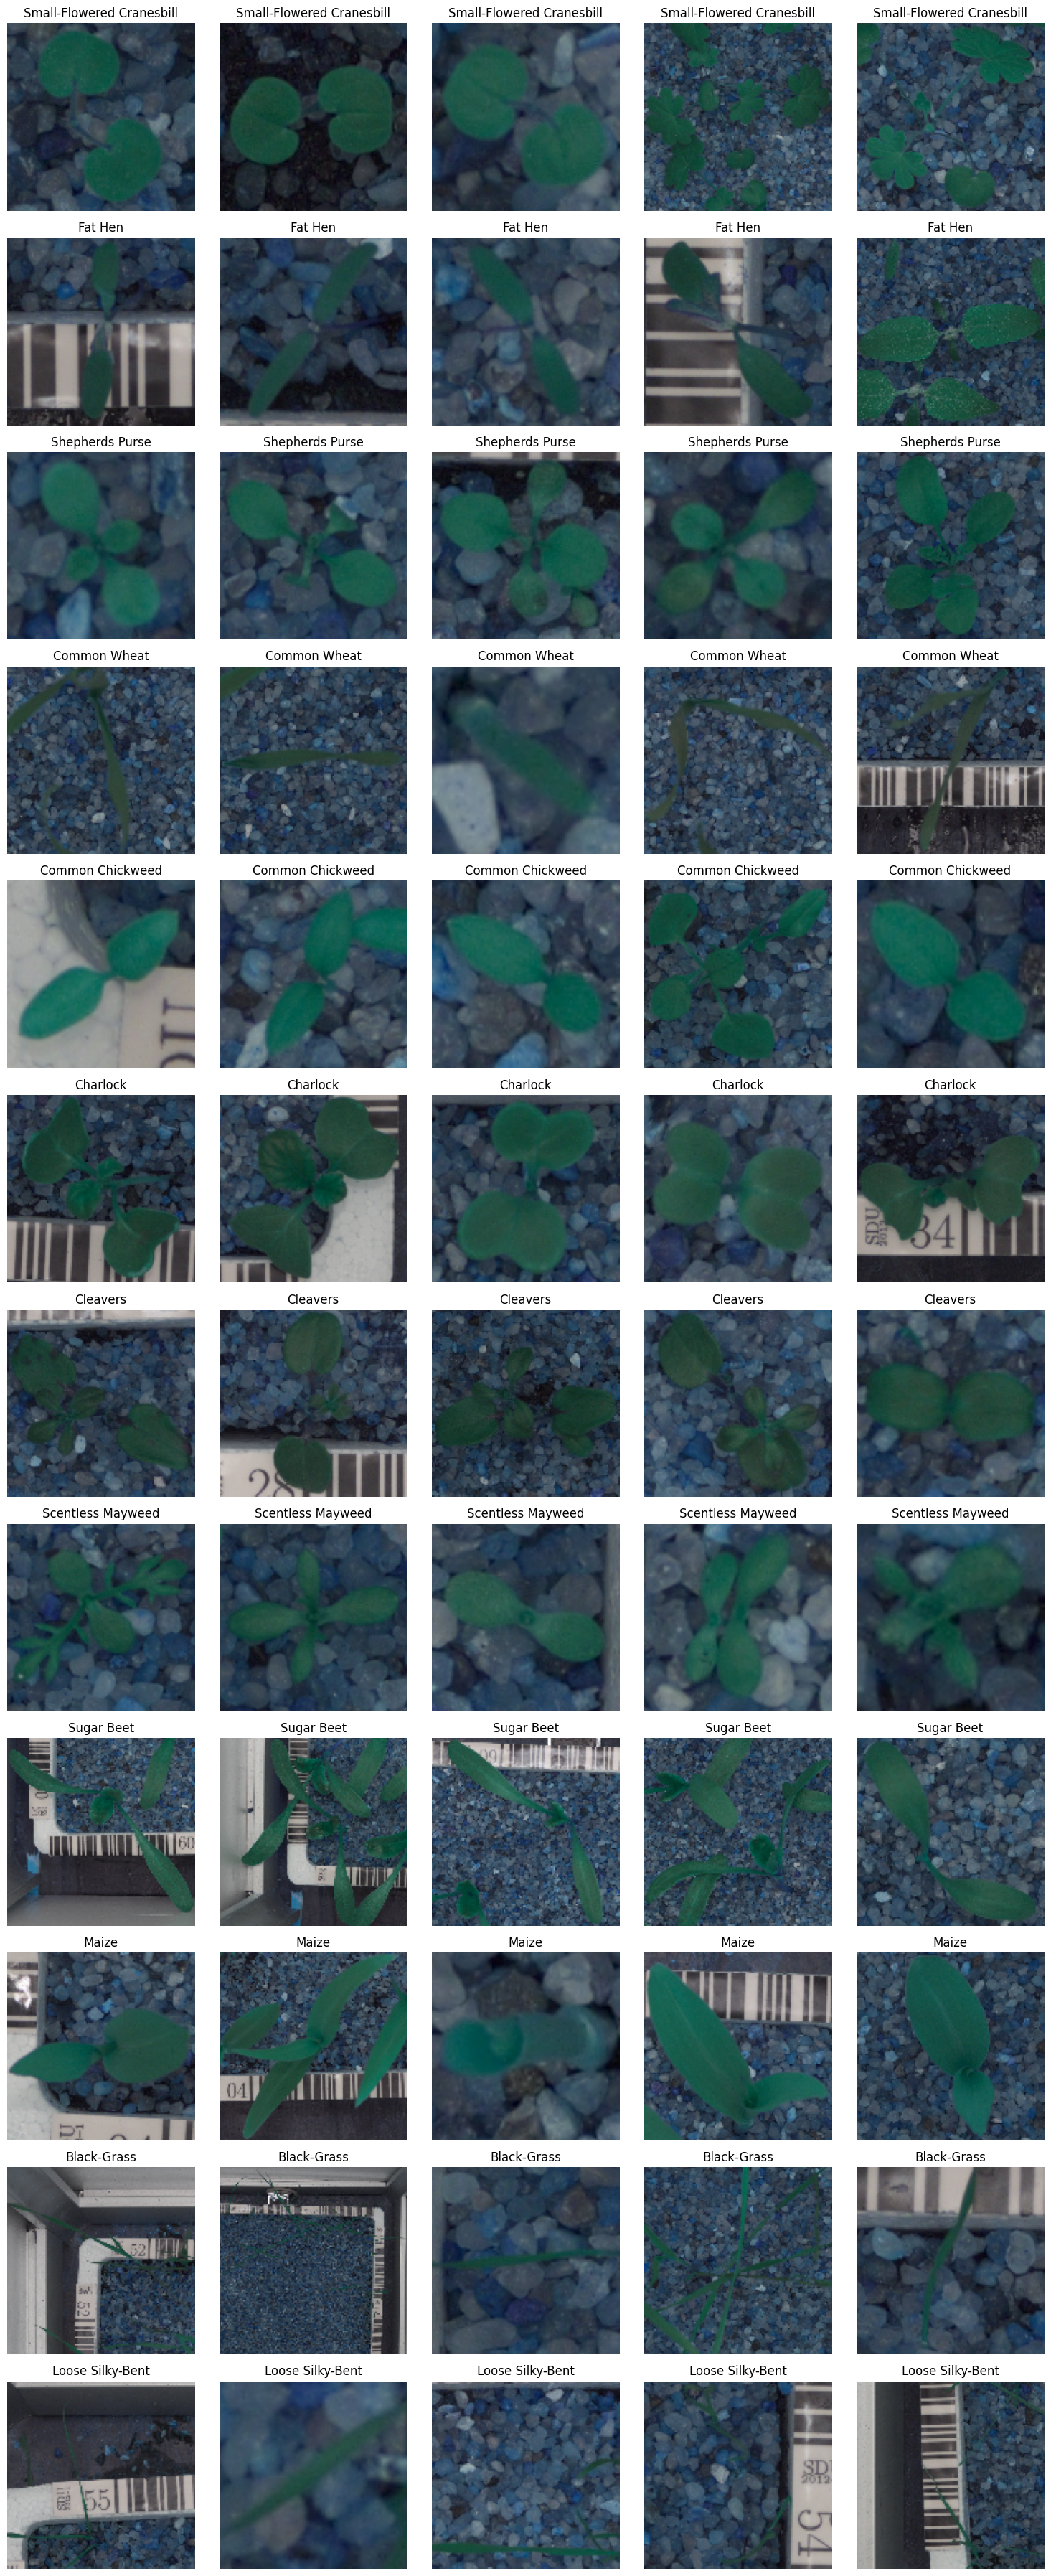

In [12]:
# Call the new function to plot random samples

plot_samples_by_class(images, labels)

#### Observations:

The plotting function successfully displayed examples of each class. **Images are generally consistent** but **certain images are out of focus**, **rotated / oriented differently than others**, **contain unique background noise**, or **are simply at different phases of the growth cycle for the plant**. This will be important to keep in mind as we begin building our model.

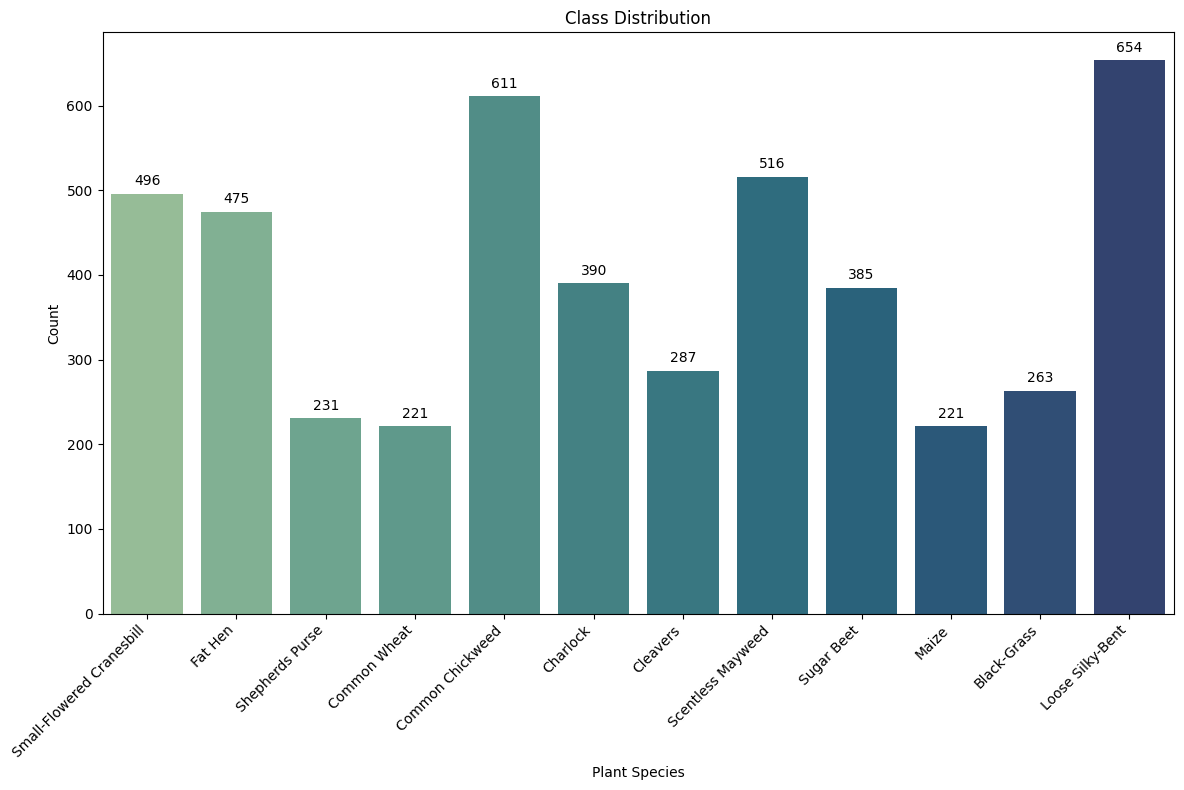

In [13]:
# Create count plot to display class distribution

plt.figure(figsize=(12, 8))
ax = sns.countplot(x=labels['Label'], palette="crest")
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution')
plt.xlabel('Plant Species')
plt.ylabel('Count')

# Add number totals above the bar for each class

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

#### Observations:

* The **Loose Silky-Bent** and **Common Chickweed classes** have the highest counts, with **over 600 samples each**. 
* The **Small-Flowered Cranesbill**, **Fat Hen**, and **Scentless Mayweed classes** have around **500 samples each**. 
* The **Charlock** and **Sugar Beet classes** have **just under 400 samples apiece**. 
* The **Black-Grass** and **Cleavers classes** have **around 250-300 samples each**. 
* The **Shepherds Purse**, **Maize**, and **Common Wheat classes** have **around 200-250 samples each**. 

### Conclusions:

* There is a noticeable imbalance where some classes (Loose Silky-Bent and Common Chickweed) have significantly more samples than others (Shepherds Purse, Maize, Common Wheat). Class imbalance can lead to a model that performs well on the majority classes but poorly on the minority classes.
* The varying quality of our images warrants some degree of concern.
* Data augmentation and adjustments to class weights will be necessary to ensure good performance on our model.

## Data Pre-Processing

### Convert BGR Images to RGB Images.

In [14]:
# Convert the images from BGR to RGB using the cvtColor function of OpenCV

for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the Images

The images are currently 128x128. In order to reduce the computational expense of training our model, images will be resized to 64x64.

#### Image Before Resizing

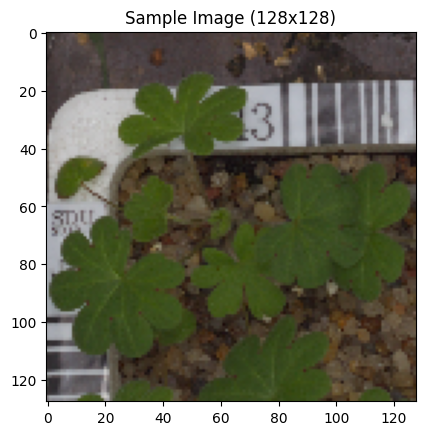

In [15]:
# Display sample image after RGB conversion before resizing

plt.imshow(images[3])
plt.title('Sample Image (128x128)')
plt.show()

#### Observations: 

Image is still legible after BGR to RGB conversion. Resizing can continue accordingly.

In [16]:
# Resize the images to 64x64 using list comprehension

images_resized = np.array([cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR) for image in images])

#### Image After Resizing

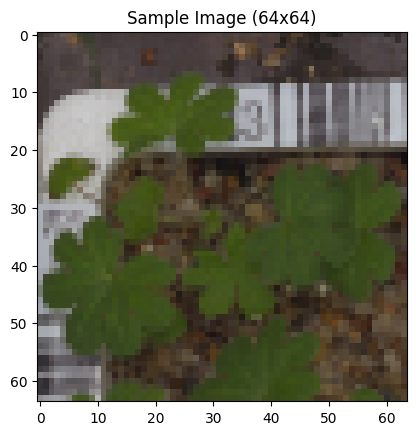

In [17]:
# Display sample image after resizing

plt.imshow(images_resized[3])
plt.title('Sample Image (64x64)')
plt.show()

#### Observations:

Image has been successfully resized to 64x64.

## Data Preparation for Modeling

### Split the Dataset

In [18]:
# Convert labels to a NumPy array for compatibility with train_test_split

labels_array = labels['Class'].values

In [19]:
# Split the data into temporary training / validation and test sets

X_temp, X_test, y_temp, y_test = train_test_split(
    np.array(images_resized), labels_array, test_size=0.1, random_state=1, stratify=labels_array)

In [20]:
# Split the temporary set into final training and validation sets

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=1, stratify=y_temp)

In [21]:
# Verify the shapes of the resulting datasets

print("Training Set Shape:", X_train.shape, y_train.shape)
print("Validation Set Shape:", X_val.shape, y_val.shape)
print("Test Set Shape:", X_test.shape, y_test.shape)

Training Set Shape: (3847, 64, 64, 3) (3847,)
Validation Set Shape: (428, 64, 64, 3) (428,)
Test Set Shape: (475, 64, 64, 3) (475,)


#### Observations:

The original dataset consists of **4750 images**. **Two 10% splits** are performed for the final training and validation sets.

* Original Dataset: **4750 images**
* Test Set (10%): **475 images**
* Remaining Data for Training and Validation: **4275 images**

From the remaining **4275 images**:

* Validation Set (10% of remaining images): **428 images**
* Training Set (the remaining images): **3847 images**

Verification of Shapes:

* Training Set Shape: **(3847, 64, 64, 3) (3847,)**
 
    * **3847 images** of **size 64x64** with **3 color channels**
    * **3847 corresponding labels**
    
    
* Validation Set Shape: **(428, 64, 64, 3) (428,)**

    * **428 images** of **size 64x64** with **3 color channels**
    * **428 corresponding labels**
    
    
* Test Set Shape: **(475, 64, 64, 3) (475,)**

    * **475 images** of **size 64x64** with **3 color channels**
    * **475 corresponding labels**

### Encode the Target Labels

In [22]:
# Convert labels to categorical format using to_categorical from Keras

y_train_encoded = to_categorical(y_train, num_classes=len(species_to_class))
y_val_encoded = to_categorical(y_val, num_classes=len(species_to_class))
y_test_encoded = to_categorical(y_test, num_classes=len(species_to_class))

In [23]:
# Verify the shapes of the encoded labels

print("Encoded y_train shape:", y_train_encoded.shape)
print("Encoded y_val shape:", y_val_encoded.shape)
print("Encoded y_test shape:", y_test_encoded.shape)

Encoded y_train shape: (3847, 12)
Encoded y_val shape: (428, 12)
Encoded y_test shape: (475, 12)


#### Observations:

Converted labels to categorical format using one-hot encoding.

The 'to_categorical' function from Keras converts integer labels to one-hot encoded labels.

Each label is represented as a vector of zeros with a single one indicating the class index.

Output Shapes:

* Training Set: **(3847, 12)**

    * **3847 samples with 12 classes** (one-hot encoded)
    
    
* Validation Set: **(428, 12)**

    * **428 samples with 12 classes** (one-hot encoded)
    
    
* Test Set: **(475, 12)**

    * **475 samples with 12 classes** (one-hot encoded)

### Data Normalization

In [24]:
# Print the original pixel value range

print(f'Original Pixel Value Range: min={images_resized.min()}, max={images_resized.max()}')

Original pixel value range: min=0, max=255


In [25]:
# Normalize the images to [0, 1] range

X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0
X_test_normalized = X_test / 255.0

In [26]:
# Verify the normalization

print(f'Pixel Range After normalization: min={X_train_normalized.min()}, max={X_train_normalized.max()}')

After normalization: min=0.0, max=1.0


#### Observations:

Initial image pixel values range [0,255] but have been normalized to values with range [0,1] to help stabilize the training process and prevent large gradients.

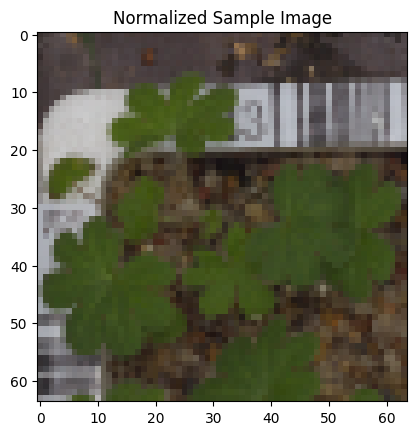

In [27]:
# Display a normalized, resized image to verify

plt.imshow(images_resized[3])
plt.title('Normalized Sample Image')
plt.show()

#### Observations: 

Image is legible and coherent after normalization.

## Model Building

### Model 1

In [28]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [29]:
# Define the CNN model

model_1 = Sequential()

# Add convolutional layers

model_1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# Flatten the output

model_1.add(Flatten())

# Add dense layers

model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(len(species_to_class), activation='softmax'))

# Compile the model

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

In [30]:
# Compute class weights to handle class imbalance

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [31]:
# Train the model

history_1 = model_1.fit(X_train_normalized, y_train_encoded, validation_data=(X_val_normalized, y_val_encoded),
                    epochs=50, batch_size=32, class_weight=class_weights)

Epoch 1/50
121/121 [==============================] - 2s 17ms/step - loss: 2.4888 - accuracy: 0.0925 - val_loss: 2.4420 - val_accuracy: 0.0584
Epoch 2/50
121/121 [==============================] - 2s 18ms/step - loss: 2.3271 - accuracy: 0.1482 - val_loss: 2.1481 - val_accuracy: 0.2126
Epoch 3/50
121/121 [==============================] - 2s 18ms/step - loss: 1.8531 - accuracy: 0.3244 - val_loss: 1.6064 - val_accuracy: 0.4416
Epoch 4/50
121/121 [==============================] - 2s 18ms/step - loss: 1.5884 - accuracy: 0.4214 - val_loss: 1.3832 - val_accuracy: 0.5257
Epoch 5/50
121/121 [==============================] - 2s 19ms/step - loss: 1.4043 - accuracy: 0.4838 - val_loss: 1.2628 - val_accuracy: 0.5911
Epoch 6/50
121/121 [==============================] - 2s 20ms/step - loss: 1.3104 - accuracy: 0.5318 - val_loss: 1.3466 - val_accuracy: 0.5304
Epoch 7/50
121/121 [==============================] - 2s 19ms/step - loss: 1.2193 - accuracy: 0.5576 - val_loss: 1.0973 - val_accuracy: 0.6706

In [32]:
# Evaluate the model on the test set

test_loss, test_accuracy = model_1.evaluate(X_test_normalized, y_test_encoded)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

15/15 [==============================] - 0s 6ms/step - loss: 0.9229 - accuracy: 0.7411
Test Loss: 0.9228620529174805
Test Accuracy: 0.7410526275634766


In [33]:
# Predict the training data outcomes

y_train_pred_encoded = model_1.predict(X_train_normalized)
y_train_pred = np.argmax(y_train_pred_encoded, axis=1)
y_train_true = np.argmax(y_train_encoded, axis=1)

# Classification report for training data

cr_train = classification_report(y_train_true, y_train_pred, target_names=species_list)
print("Classification Report for Training Data:")
print(cr_train)

121/121 [==============================] - 1s 5ms/step
Classification Report for Training Data:
                           precision    recall  f1-score   support

              Black-Grass       0.99      0.92      0.95       213
                 Charlock       1.00      0.99      1.00       316
                 Cleavers       1.00      1.00      1.00       232
         Common Chickweed       0.98      1.00      0.99       495
             Common Wheat       0.97      0.99      0.98       179
                  Fat Hen       0.98      0.99      0.99       384
         Loose Silky-Bent       0.96      0.99      0.98       530
                    Maize       0.99      0.99      0.99       179
        Scentless Mayweed       0.99      0.98      0.98       418
          Shepherds Purse       0.98      1.00      0.99       187
Small-Flowered Cranesbill       1.00      0.99      1.00       402
               Sugar Beet       1.00      0.98      0.99       312

                 accuracy      

#### Observations:

**Training Data Performance**:

* Overall Accuracy: 99%
* Macro Avg: Precision 0.99, Recall 0.98, F1-score 0.99
* Weighted Avg: Precision 0.99, Recall 0.99, F1-score 0.99

**High Precision, Recall, and F1-Scores**: The precision, recall, and F1-score values are very high (mostly close to 1.0) for all classes, indicating that the model correctly identifies most instances of each class without many false positives or false negatives.

**High Overall Accuracy**: The overall accuracy is 99%, indicating that the model correctly classifies 99% of the training data instances.

In [34]:
# Predict the validation data outcomes

y_val_pred_encoded = model_1.predict(X_val_normalized)
y_val_pred = np.argmax(y_val_pred_encoded, axis=1)
y_val_true = np.argmax(y_val_encoded, axis=1)

# Classification report for validation data

cr_val = classification_report(y_val_true, y_val_pred, target_names=species_list)
print("Classification Report for Validation Data:")
print(cr_val)

14/14 [==============================] - 0s 5ms/step
Classification Report for Validation Data:
                           precision    recall  f1-score   support

              Black-Grass       0.45      0.38      0.41        24
                 Charlock       0.88      0.83      0.85        35
                 Cleavers       0.86      0.73      0.79        26
         Common Chickweed       0.74      0.96      0.83        55
             Common Wheat       0.73      0.55      0.63        20
                  Fat Hen       0.87      0.77      0.81        43
         Loose Silky-Bent       0.70      0.88      0.78        59
                    Maize       0.93      0.65      0.76        20
        Scentless Mayweed       0.69      0.76      0.72        46
          Shepherds Purse       0.55      0.29      0.37        21
Small-Flowered Cranesbill       0.91      0.91      0.91        44
               Sugar Beet       0.88      0.86      0.87        35

                 accuracy      

#### Observations:

**Validation Data Performance**:

* Overall Accuracy: 77%
* Macro Avg: Precision 0.77, Recall 0.71, F1-score 0.73
* Weighted Avg: Precision 0.77, Recall 0.77, F1-score 0.76

The overall accuracy on the validation set is 77%, which is significantly lower than the nearly perfect accuracy on the training set. This indicates that the model may be overfitting to the training data.

**Precision, Recall, and F1-Score**: The precision, recall, and F1-scores vary significantly across different classes. For example:

* **Common Chickweed**: High precision (0.74) and recall (0.96), indicating the model performs well for this class.

* **Black-Grass**: Lower precision (0.45) and recall (0.38), indicating poorer performance for this class.

* **Shepherds Purse**: Particularly low recall (0.29) and F1-score (0.37), suggesting difficulty in correctly identifying instances of this class.

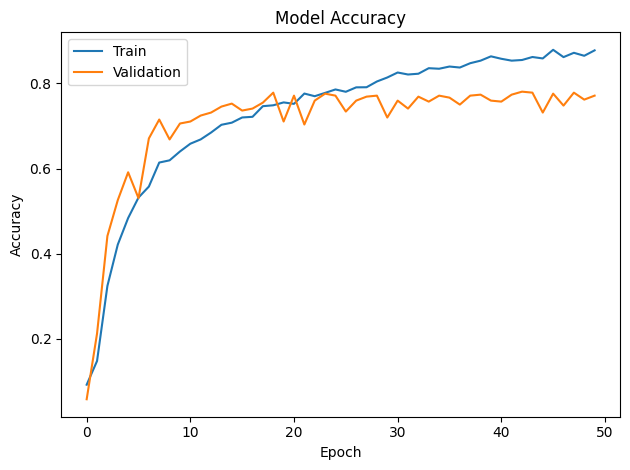

In [35]:
# Plot training & validation accuracy values

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

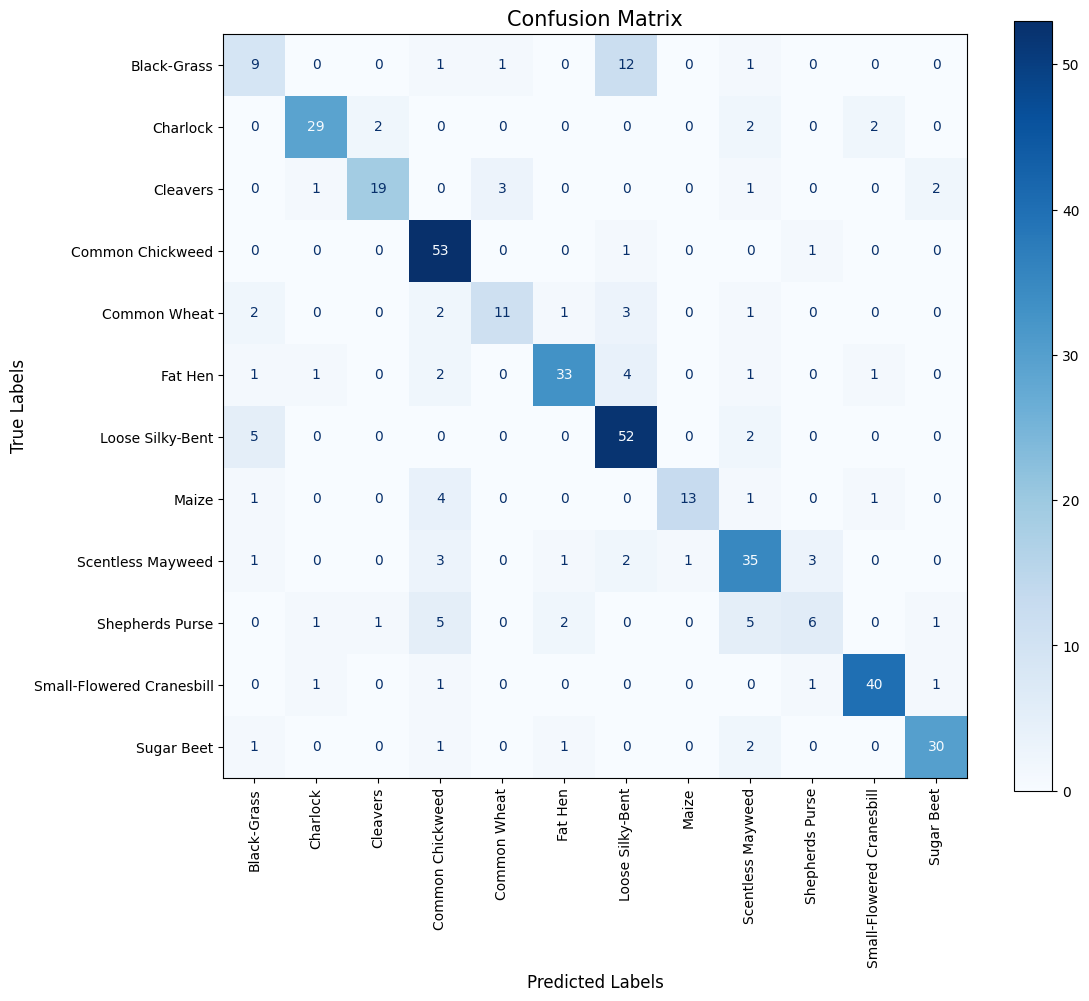

In [36]:
# Compute the confusion matrix

conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Display the confusion matrix with enhanced readability

fig, ax = plt.subplots(figsize=(12, 10))  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=species_list)
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)  # Rotate x-axis labels

# Customize font size

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

plt.show()

#### Observations:

The model is **likely overfitting to the training data**, as indicated by the high training performance and lower validation performance. This suggests the model has learned the training data too well, including noise and specific patterns that don't generalize.

**Training Performance**: The model learns well on the training data, achieving high accuracy and low loss.

**Validation Performance**: The validation accuracy is reasonable, but the increasing validation loss suggests overfitting.

The performance metrics indicate that some classes are harder for the model to predict correctly, which could be due to class imbalance or inherent difficulty in distinguishing these classes.

## Model Performance Improvement

### Model 2

In [37]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [38]:
# Define the CNN model

model_2 = Sequential()

# Add convolutional layers

model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

# Flatten the output

model_2.add(Flatten())

# Add dense layers

model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(len(species_to_class), activation='softmax'))

# Compile the model

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

### Data Augmentation

In [39]:
# Compute class weights to handle class imbalance

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Data augmentation

datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest')

In [40]:
# Train the model

history_2 = model_2.fit(datagen.flow(X_train_normalized, y_train_encoded, batch_size=32),
                    validation_data=(X_val_normalized, y_val_encoded),
                    epochs=50, class_weight=class_weights, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
121/121 [==============================] - 3s 21ms/step - loss: 2.4974 - accuracy: 0.0819 - val_loss: 2.4796 - val_accuracy: 0.0654 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 2s 20ms/step - loss: 2.4362 - accuracy: 0.1029 - val_loss: 2.2474 - val_accuracy: 0.1893 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 3s 21ms/step - loss: 2.0298 - accuracy: 0.2529 - val_loss: 1.7242 - val_accuracy: 0.4790 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 3s 21ms/step - loss: 1.7358 - accuracy: 0.3629 - val_loss: 1.4598 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 2s 21ms/step - loss: 1.5548 - accuracy: 0.4331 - val_loss: 1.3678 - val_accuracy: 0.5654 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 3s 21ms/step - loss: 1.4893 - accuracy: 0.4432 - val_loss: 1.2581 - val_accuracy: 0.6121 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 3s 21ms/st

In [41]:
# Evaluate the model on the test set

test_loss, test_accuracy = model_2.evaluate(X_test_normalized, y_test_encoded)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

15/15 [==============================] - 0s 5ms/step - loss: 0.7728 - accuracy: 0.7474
Test Loss: 0.7727676630020142
Test Accuracy: 0.7473683953285217


In [42]:
# Predict the training data outcomes

y_train_pred_encoded = model_2.predict(X_train_normalized)
y_train_pred = np.argmax(y_train_pred_encoded, axis=1)
y_train_true = np.argmax(y_train_encoded, axis=1)

# Classification report for training data

cr_train = classification_report(y_train_true, y_train_pred, target_names=species_list)
print("Classification Report for Training Data:")
print(cr_train)

121/121 [==============================] - 1s 5ms/step
Classification Report for Training Data:
                           precision    recall  f1-score   support

              Black-Grass       0.46      0.71      0.56       213
                 Charlock       0.93      0.97      0.95       316
                 Cleavers       0.86      0.94      0.89       232
         Common Chickweed       0.97      0.91      0.94       495
             Common Wheat       0.73      0.84      0.78       179
                  Fat Hen       0.92      0.82      0.87       384
         Loose Silky-Bent       0.89      0.60      0.72       530
                    Maize       0.89      0.98      0.93       179
        Scentless Mayweed       0.83      0.89      0.86       418
          Shepherds Purse       0.73      0.86      0.79       187
Small-Flowered Cranesbill       0.94      0.92      0.93       402
               Sugar Beet       0.92      0.89      0.90       312

                 accuracy      

#### Observations:

**Training Data Performance**:

* Overall Accuracy: 85%
* Macro Avg: Precision 0.84, Recall 0.86, F1-score 0.84
* Weighted Avg: Precision 0.87, Recall 0.85, F1-score 0.85

Overfitting seems less likely here. The **Black-Grass** precision score of 0.46, recall score of 0.71, and F1-score of 0.56 appear to be outliers here, perhaps indicating difficulty classifying these images.

In [43]:
# Predict the validation data outcomes

y_val_pred_encoded = model_2.predict(X_val_normalized)
y_val_pred = np.argmax(y_val_pred_encoded, axis=1)
y_val_true = np.argmax(y_val_encoded, axis=1)

# Classification report for validation data

cr_val = classification_report(y_val_true, y_val_pred, target_names=species_list)
print("Classification Report for Validation Data:")
print(cr_val)

14/14 [==============================] - 0s 5ms/step
Classification Report for Validation Data:
                           precision    recall  f1-score   support

              Black-Grass       0.42      0.67      0.52        24
                 Charlock       0.84      0.89      0.86        35
                 Cleavers       0.81      0.85      0.83        26
         Common Chickweed       0.91      0.93      0.92        55
             Common Wheat       0.57      0.60      0.59        20
                  Fat Hen       0.82      0.72      0.77        43
         Loose Silky-Bent       0.80      0.56      0.66        59
                    Maize       0.76      0.80      0.78        20
        Scentless Mayweed       0.69      0.78      0.73        46
          Shepherds Purse       0.69      0.52      0.59        21
Small-Flowered Cranesbill       0.91      0.91      0.91        44
               Sugar Beet       0.84      0.89      0.86        35

                 accuracy      

#### Observations:

**Validation Data Performance**:

* Overall Accuracy: 77%
* Macro Avg: Precision 0.76, Recall 0.76, F1-score 0.75
* Weighted Avg: Precision 0.78, Recall 0.77, F1-score 0.77

The **Black-Grass** precision score of 0.42, recall score of 0.67, and F1-score of 0.52, **Common Wheat** precision score of 0.57, recall score of 0.60, and F1-score of 0.59, and **Shepherds Purse** precision score of 0.69, recall score of 0.52, and F1-score of 0.59 appear to be outliers here, perhaps indicating difficulty classifying these images.

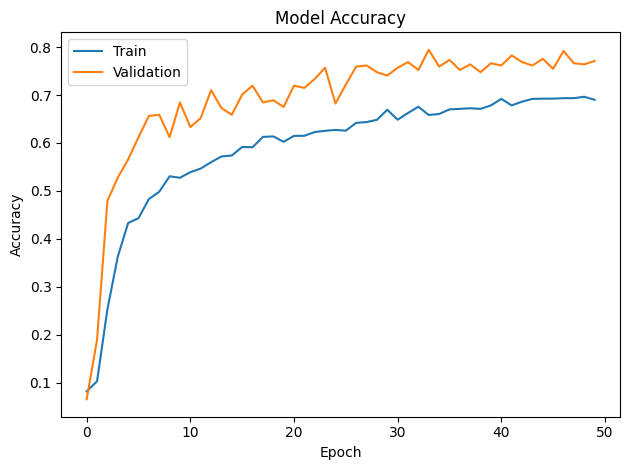

In [44]:
# Plot training & validation accuracy values

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

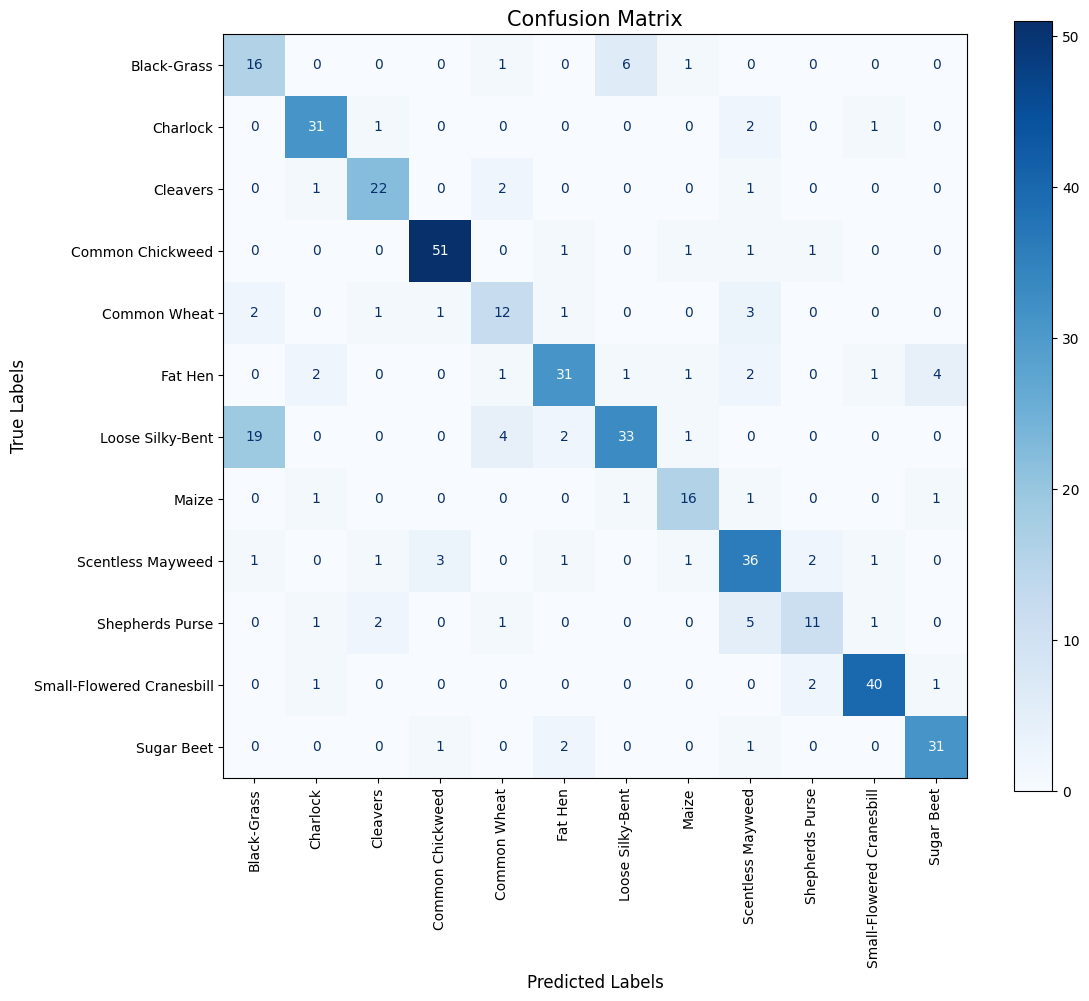

In [45]:
# Compute the confusion matrix

conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Display the confusion matrix with enhanced readability

fig, ax = plt.subplots(figsize=(12, 10))  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=species_list)
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)

# Customize font size

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

plt.show()

#### Observations:

Overfitting appears to be less of an issue on this model but there are concerns about the model's ability to accurately classify certain image classes.

### Model 3

In [46]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [47]:
model_3 = Sequential()

# Add more convolutional layers and different activation functions

model_3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.3))

model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.3))

model_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.4))

model_3.add(Flatten())

model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(len(species_to_class), activation='softmax'))

# Compile the model

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

In [48]:
# Compute class weights to handle class imbalance

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Data augmentation

datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest')

# Adjust learning rate and fit the model again

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
# Continue with the existing training code with early stopping and learning rate reduction callbacks

history_3 = model_3.fit(datagen.flow(X_train_normalized, y_train_encoded, batch_size=32),
                    validation_data=(X_val_normalized, y_val_encoded),
                    epochs=50, class_weight=class_weights, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
121/121 [==============================] - 3s 26ms/step - loss: 2.4554 - accuracy: 0.0842 - val_loss: 2.1993 - val_accuracy: 0.2173 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 3s 26ms/step - loss: 1.9490 - accuracy: 0.2906 - val_loss: 1.7052 - val_accuracy: 0.4136 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 3s 26ms/step - loss: 1.6912 - accuracy: 0.3767 - val_loss: 1.4112 - val_accuracy: 0.5748 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 3s 26ms/step - loss: 1.4926 - accuracy: 0.4526 - val_loss: 1.2628 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 3s 25ms/step - loss: 1.2696 - accuracy: 0.5422 - val_loss: 1.0782 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 3s 26ms/step - loss: 1.1804 - accuracy: 0.5885 - val_loss: 0.9702 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 3s 26ms/st

In [50]:
# Evaluate the model on the test set

test_loss, test_accuracy = model_3.evaluate(X_test_normalized, y_test_encoded)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

15/15 [==============================] - 0s 8ms/step - loss: 0.4863 - accuracy: 0.8568
Test Loss: 0.48627662658691406
Test Accuracy: 0.8568421006202698


In [51]:
# Predict the training data outcomes

y_train_pred_encoded = model_3.predict(X_train_normalized)
y_train_pred = np.argmax(y_train_pred_encoded, axis=1)
y_train_true = np.argmax(y_train_encoded, axis=1)

# Classification report for training data

cr_train = classification_report(y_train_true, y_train_pred, target_names=species_list)
print("Classification Report for Training Data:")
print(cr_train)

121/121 [==============================] - 1s 7ms/step
Classification Report for Training Data:
                           precision    recall  f1-score   support

              Black-Grass       0.64      0.91      0.75       213
                 Charlock       0.99      0.99      0.99       316
                 Cleavers       0.99      0.99      0.99       232
         Common Chickweed       0.99      0.99      0.99       495
             Common Wheat       0.95      1.00      0.97       179
                  Fat Hen       0.99      0.98      0.99       384
         Loose Silky-Bent       0.96      0.78      0.86       530
                    Maize       0.99      0.99      0.99       179
        Scentless Mayweed       0.97      0.99      0.98       418
          Shepherds Purse       0.98      0.98      0.98       187
Small-Flowered Cranesbill       1.00      0.99      0.99       402
               Sugar Beet       1.00      0.99      1.00       312

                 accuracy      

#### Observations:

**Training Data Performance**:

* Overall Accuracy: 96%
* Macro Average: Precision 0.95, Recall 0.97, F1-score 0.96
* Weighted Average: Precision 0.96, Recall 0.96, F1-score 0.96

Aside from issues with low precision and F1-scores for **Black-Grass**, the training data performance is unusually high, **likely indicating issues with overfitting**.

In [52]:
# Predict the validation data outcomes

y_val_pred_encoded = model_3.predict(X_val_normalized)
y_val_pred = np.argmax(y_val_pred_encoded, axis=1)
y_val_true = np.argmax(y_val_encoded, axis=1)

# Classification report for validation data

cr_val = classification_report(y_val_true, y_val_pred, target_names=species_list)
print("Classification Report for Validation Data:")
print(cr_val)

14/14 [==============================] - 0s 7ms/step
Classification Report for Validation Data:
                           precision    recall  f1-score   support

              Black-Grass       0.45      0.75      0.56        24
                 Charlock       0.86      0.89      0.87        35
                 Cleavers       0.91      0.81      0.86        26
         Common Chickweed       0.93      0.96      0.95        55
             Common Wheat       0.70      0.80      0.74        20
                  Fat Hen       0.88      0.81      0.84        43
         Loose Silky-Bent       0.85      0.56      0.67        59
                    Maize       0.76      0.80      0.78        20
        Scentless Mayweed       0.84      0.93      0.89        46
          Shepherds Purse       0.79      0.71      0.75        21
Small-Flowered Cranesbill       0.95      0.93      0.94        44
               Sugar Beet       0.92      0.94      0.93        35

                 accuracy      

#### Observations:

**Validation Data Performance**:

* Overall Accuracy: 83%
* Macro Average: Precision 0.82, Recall 0.83, F1-score 0.82
* Weighted Average: Precision 0.85, Recall 0.83, F1-score 0.83

The model performs well on the validation data but struggles to classify **Black-Grass** and **Loose Silky-Bent** compared to other image classes.

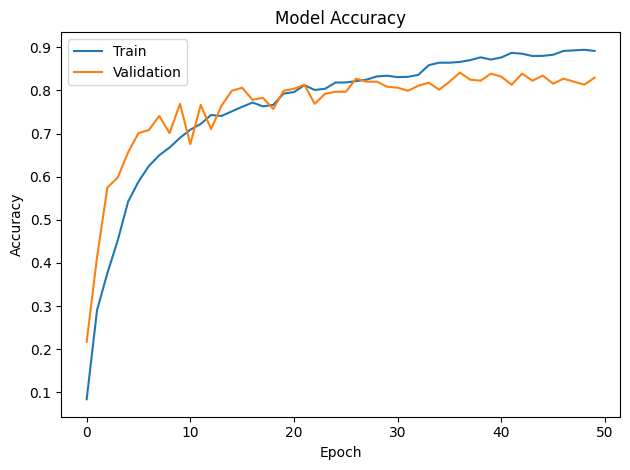

In [53]:
# Plot training & validation accuracy values

plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

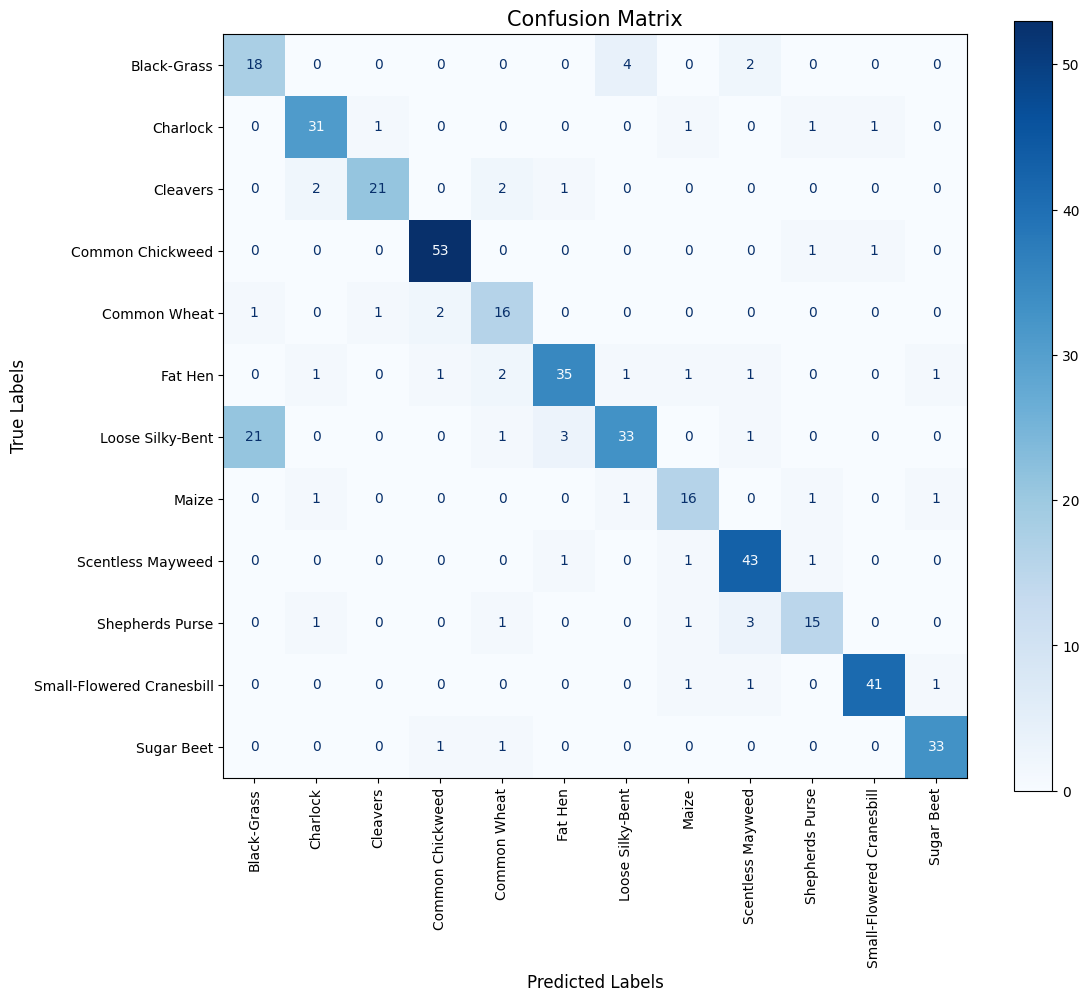

In [54]:
# Compute the confusion matrix

conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Display the confusion matrix with enhanced readability

fig, ax = plt.subplots(figsize=(12, 10))  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=species_list)
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)

# Customize font size

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

plt.show()

#### Observations:

Issues with overfitting:

* The **significant difference between the training and validation accuracy indicates overfitting**. The model performs exceptionally well on the training data but struggles to generalize to the validation data.

* Some classes, like **Black-Grass** and **Loose Silky-Bent**, have **lower precision and recall on the validation set, indicating difficulty in accurately classifying these classes**.

* Other classes, such as **Common Chickweed**, **Charlock**, and **Cleavers**, have **high precision and recall, indicating better performance for these classes**.

### Model 4

In [55]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [56]:
model_4 = Sequential()

# Add more convolutional layers and different activation functions

model_4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(0.001)))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.3))

model_4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.4))

model_4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.5))

model_4.add(Flatten())

model_4.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_4.add(Dropout(0.5))
model_4.add(Dense(len(species_to_class), activation='softmax'))

# Compile the model

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest')

# Callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [58]:
# Continue with the existing training code with early stopping and learning rate reduction callbacks

history_4 = model_4.fit(datagen.flow(X_train_normalized, y_train_encoded, batch_size=32),
                        validation_data=(X_val_normalized, y_val_encoded),
                        epochs=50, class_weight=class_weights, 
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/50
121/121 [==============================] - 3s 26ms/step - loss: 2.8841 - accuracy: 0.0860 - val_loss: 2.6343 - val_accuracy: 0.2243 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 3s 26ms/step - loss: 2.2766 - accuracy: 0.2360 - val_loss: 1.9820 - val_accuracy: 0.3762 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 3s 26ms/step - loss: 1.9684 - accuracy: 0.3319 - val_loss: 1.7424 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 3s 27ms/step - loss: 1.7803 - accuracy: 0.3980 - val_loss: 1.6103 - val_accuracy: 0.4790 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 3s 26ms/step - loss: 1.6567 - accuracy: 0.4580 - val_loss: 1.4717 - val_accuracy: 0.5888 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 3s 26ms/step - loss: 1.5536 - accuracy: 0.5121 - val_loss: 1.4400 - val_accuracy: 0.5888 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 3s 26ms/st

In [59]:
# Predict the training data outcomes

y_train_pred_encoded = model_4.predict(X_train_normalized)
y_train_pred = np.argmax(y_train_pred_encoded, axis=1)
y_train_true = np.argmax(y_train_encoded, axis=1)

# Classification report for training data

cr_train = classification_report(y_train_true, y_train_pred, target_names=species_list)
print("Classification Report for Training Data:")
print(cr_train)

121/121 [==============================] - 1s 7ms/step
Classification Report for Training Data:
                           precision    recall  f1-score   support

              Black-Grass       0.43      0.80      0.56       213
                 Charlock       0.95      0.98      0.97       316
                 Cleavers       0.94      0.94      0.94       232
         Common Chickweed       0.96      0.98      0.97       495
             Common Wheat       0.82      0.97      0.89       179
                  Fat Hen       0.95      0.91      0.93       384
         Loose Silky-Bent       0.92      0.53      0.67       530
                    Maize       0.94      0.99      0.96       179
        Scentless Mayweed       0.92      0.90      0.91       418
          Shepherds Purse       0.90      0.93      0.91       187
Small-Flowered Cranesbill       0.99      0.98      0.98       402
               Sugar Beet       0.96      0.96      0.96       312

                 accuracy      

#### Observations:

**Training Data Performance**:

* Overall Accuracy: 89%
* Macro Avg: Precision 0.89, Recall 0.91, F1-score 0.89
* Weighted Avg: Precision 0.91, Recall 0.89, F1-score 0.89

The model struggles to accurately classify **Black-Grass** and **Loose Silky-Bent** but performs well on all other image classes.

In [60]:
# Predict the validation data outcomes

y_val_pred_encoded = model_4.predict(X_val_normalized)
y_val_pred = np.argmax(y_val_pred_encoded, axis=1)
y_val_true = np.argmax(y_val_encoded, axis=1)

# Classification report for validation data

cr_val = classification_report(y_val_true, y_val_pred, target_names=species_list)
print("Classification Report for Validation Data:")
print(cr_val)

14/14 [==============================] - 0s 8ms/step
Classification Report for Validation Data:
                           precision    recall  f1-score   support

              Black-Grass       0.43      0.83      0.56        24
                 Charlock       0.84      0.91      0.88        35
                 Cleavers       0.85      0.85      0.85        26
         Common Chickweed       0.92      0.98      0.95        55
             Common Wheat       0.70      0.80      0.74        20
                  Fat Hen       0.85      0.79      0.82        43
         Loose Silky-Bent       0.89      0.53      0.66        59
                    Maize       0.77      0.85      0.81        20
        Scentless Mayweed       0.82      0.78      0.80        46
          Shepherds Purse       0.72      0.62      0.67        21
Small-Flowered Cranesbill       0.97      0.86      0.92        44
               Sugar Beet       0.86      0.91      0.89        35

                 accuracy      

#### Observations:

**Validation Data Performance**:

* Overall Accuracy: 81%
* Macro Avg: Precision 0.80, Recall 0.81, F1-score 0.79
* Weighted Avg: Precision 0.83, Recall 0.81, F1-score 0.81

The model struggles to accurately classify **Black-Grass**, **Shepherds Purse**, and **Loose Silky-Bent** but performs relatively well on all other image classes.

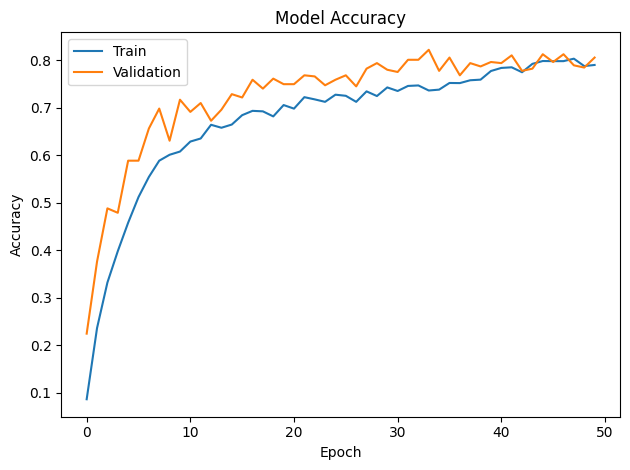

In [61]:
# Plot training & validation accuracy values

plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

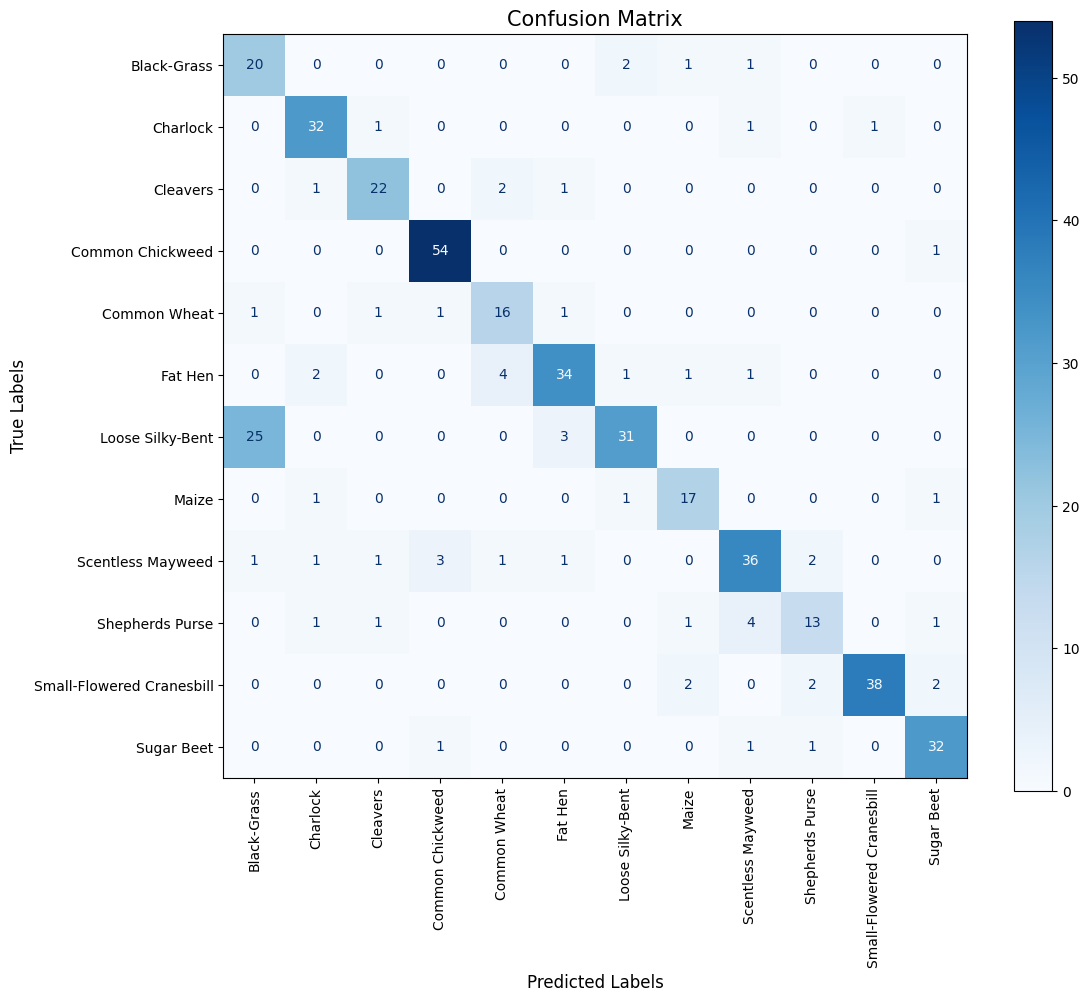

In [62]:
# Compute the confusion matrix

conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Display the confusion matrix with enhanced readability

fig, ax = plt.subplots(figsize=(12, 10))  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=species_list)
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)

# Customize font size

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

plt.show()

#### Observations:

There is still a **notable gap between the training accuracy (89%) and validation accuracy (81%)**. This indicates that **the model might still be overfitting to some extent**.

The **Black-Grass** and **Loose Silky-Bent** classes have a significant difference in precision and recall between training and validation, suggesting difficulty in generalizing for these classes.

The **Common Chickweed** and **Charlock** classes perform well in both training and validation, indicating good generalization.

## Final Model Selection

**Model 4 was chosen as the final model** for the project **due to its more reasonable 89% training accuracy** and **81% validation accuracy**. Other models featured training accuracy of nearly 99% but failed to generalize appropriately on the validation data, resulting in much-lower accuracy indicating a significant problem with overfitting to the train data.

### Visualizing the prediction

In [63]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

1/1 [==============================] - 0s 14ms/step


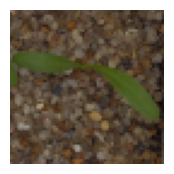

True Label: 11
Predicted Label: 11
1/1 [==============================] - 0s 8ms/step


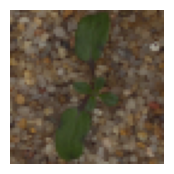

True Label: 2
Predicted Label: 2
1/1 [==============================] - 0s 8ms/step


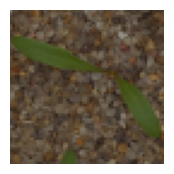

True Label: 11
Predicted Label: 11
1/1 [==============================] - 0s 7ms/step


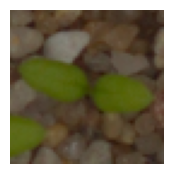

True Label: 3
Predicted Label: 3


In [65]:
# Define and fit the LabelBinarizer encoder

enc = LabelBinarizer()
enc.fit(y_train)  

# Function to plot an image and display predicted and true labels

def plot_image_with_predictions(image, true_label, predicted_label):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print('True Label:', true_label)
    print('Predicted Label:', predicted_label)

# Select indices of images to visualize

indices_to_visualize = [3, 22, 51, 43]

# Loop through selected indices to visualize images, predicted labels, and true labels

for idx in indices_to_visualize:
    
    # Get the image from the test set
    
    image = X_test[idx]
    
    # Normalize the image for prediction
    
    normalized_image = X_test_normalized[idx].reshape(1, 64, 64, 3)
    
    # Get the true label from the test set
    
    true_label = enc.inverse_transform(np.array([y_test_encoded[idx]]))[0]
    
    # Predict the label using the model
    
    predicted_label = enc.inverse_transform(model_4.predict(normalized_image))[0]
    
    # Plot the image with predicted and true labels
    
    plot_image_with_predictions(image, true_label, predicted_label)

#### Observations:

Model 4 successfully predicts the true label for the 4 random images from the dataset indicating high accuracy.

## Actionable Insights and Business Recommendations

**Hypothetical Improvements for the Model** 

* **Increase Dataset Size and Diversity**: Collect more images across different growth stages, lighting conditions, and backgrounds. Use more extensive data augmentation techniques such as random crops, horizontal flips, and varying brightness to increase dataset diversity.

* **Transfer Learning**: Utilize more advanced pre-trained models like EfficientNet, InceptionV3, or ResNet152 which might provide better feature extraction capabilities. Fine-tune these models on our specific dataset to leverage their pre-trained weights on large-scale datasets.

* **Active Learning**: Implement active learning where the model iteratively queries the user to label the most informative samples. This approach could help in making the model more robust by focusing on hard-to-classify examples.

**Business Recommendations**

* **Integration with Mobile Applications**: Develop a mobile application that utilizes the trained model to identify plants in real-time using the device’s camera. Ensure the app provides information about the plant, growth stage, and care instructions.

* **Field Monitoring Systems**: Integrate the model into IoT devices equipped with cameras for continuous field monitoring. These systems can alert farmers about plant health and growth stages, helping in timely intervention and decision-making.

* **Precision Agriculture**: Combine the model with other precision agriculture tools like soil sensors, weather data, and satellite imagery for more comprehensive farm management. Provide actionable insights for crop management, pest control, and yield optimization based on data-driven predictions.

* **Continuous Improvement and Feedback Loop**: Establish a feedback loop where farmers can provide data about model performance in the field. Use this feedback to continuously improve the model and its accuracy in real-world conditions.